In [2]:
import numpy as np
import pandas as pd
import pcreode
import math
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings( 'ignore')

In [3]:
file_nm = "/home/herrinca/Data/Eliot/paper_segmentation/ileum/Ileum_for_chuck_no_cd3_RAW_Ken_markers_no_CD44v10_RFP_pH3_greater_than_3.csv"
data_raw = pd.read_csv( file_nm)

In [214]:
data = get_data( 2)

In [4]:
# select for meaningful columns
col_names = [u'Median_Cell_Hopx',     u'Median_Nuc_PCNA',       u'Median_Cell_GFP',
             u'Median_Nuc_Sox9',     u'Median_Nuc_Survivin',  u'Median_Memb_CK20',      u'Median_Cell_ChromA', 
             u'Median_Cell_DCLK1',   u'Median_Cell_Lysozyme', u'Median_Cell_Muc2',      u'Median_Memb_pEGFR', 
             u'Median_Nuc_Ki67',     u'Median_Memb_Villin'] 
            #u'Median_Cell_CD44v10', u'Median_Cell_RFPCy5', u'Median_Nuc_pHistoneH3' 

data = pd.DataFrame( data_raw, columns=col_names)

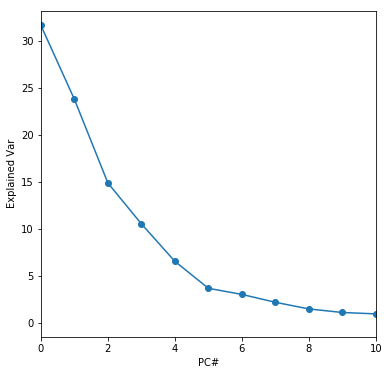

In [5]:
data_pca = pcreode.PCA( data)
data_pca.get_pca()
data_pca.pca_plot_explained_var( xlim=(0,10))

In [6]:
pca_test_data = data_pca.pca_set_components( 7)

(Text(0.5,0,'PC5'), Text(0,0.5,'PC4'))

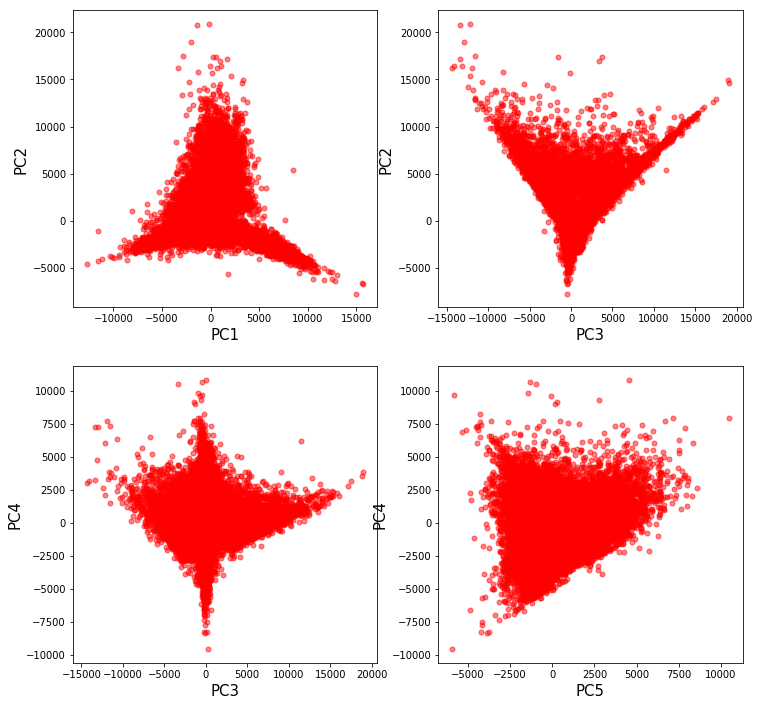

In [7]:
fig = plt.figure( figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
cc = 'r'
ax1.scatter( pca_test_data[:,0], pca_test_data[:,1], alpha=0.5, s=25, c=cc)
ax2.scatter( pca_test_data[:,2], pca_test_data[:,1], alpha=0.5, s=25, c=cc)
ax3.scatter( pca_test_data[:,2], pca_test_data[:,3], alpha=0.5, s=25, c=cc)
ax4.scatter( pca_test_data[:,4], pca_test_data[:,3], alpha=0.5, s=25, c=cc)
ax1.set_xlabel("PC1", fontsize=15), ax1.set_ylabel("PC2", fontsize=15)
ax2.set_xlabel("PC3", fontsize=15), ax2.set_ylabel("PC2", fontsize=15)
ax3.set_xlabel("PC3", fontsize=15), ax3.set_ylabel("PC4", fontsize=15)
ax4.set_xlabel("PC5", fontsize=15), ax4.set_ylabel("PC4", fontsize=15)

In [8]:
data = data_pca.pca_set_components( 7)

best guess starting radius = 2233.43979701


2233.4397970119026

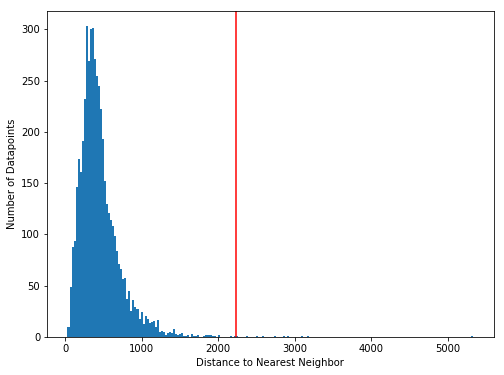

In [9]:
dens = pcreode.Density( data)
dens.nearest_neighbor_hist()

calculating densities for datapoints: 0 -> 4999
calculating densities for datapoints: 5000 -> 9999
calculating densities for datapoints: 10000 -> 14999
calculating densities for datapoints: 15000 -> 19999
calculating densities for datapoints: 20000 -> 24999
calculating densities for datapoints: 25000 -> 29999
calculating densities for datapoints: 30000 -> 34999
calculating densities for datapoints: 35000 -> 39241
****Always check density overlay for radius fit****


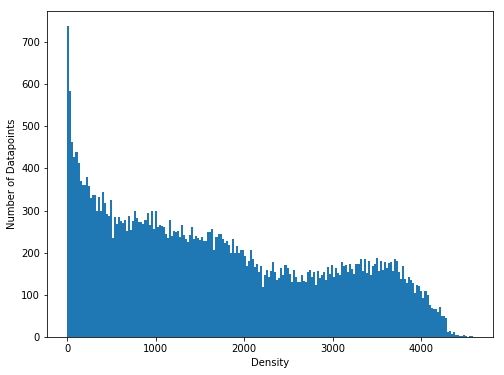

In [10]:
density = dens.get_density( radius=2233)
dens.density_hist( n_bins=200)

(Text(0.5,0,'PC3'), Text(0,0.5,'PC2'))

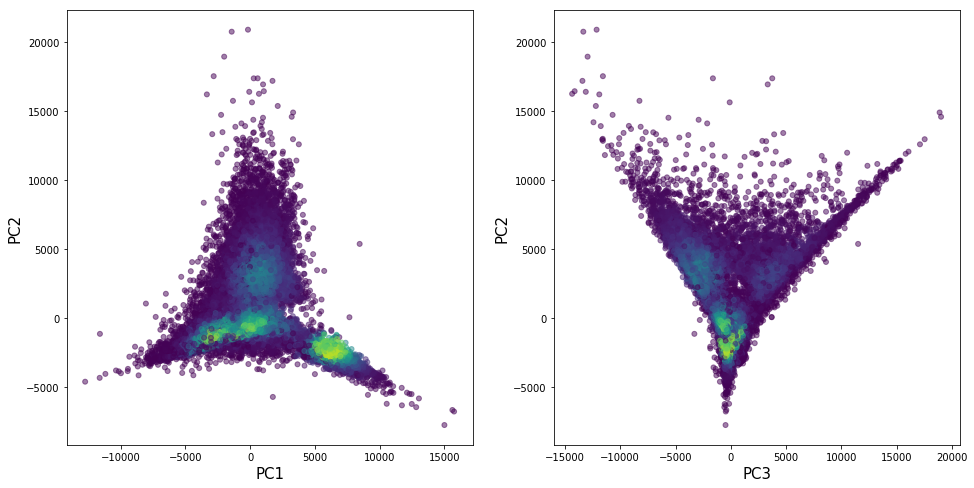

In [12]:
fig = plt.figure( figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
cc = density
ax1.scatter( data[:,0], data[:,1], alpha=0.5, s=25, c=cc)
ax2.scatter( data[:,2], data[:,1], alpha=0.5, s=25, c=cc)
ax1.set_xlabel("PC1", fontsize=15), ax1.set_ylabel("PC2", fontsize=15)
ax2.set_xlabel("PC3", fontsize=15), ax2.set_ylabel("PC2", fontsize=15)

In [13]:
noise  = 10.0
target = 15.0

In [14]:
downed, downed_ind = pcreode.Down_Sample( data, density, noise, target)

Number of data points in downsample = 10432


(Text(0.5,0,'PC3'), Text(0,0.5,'PC2'))

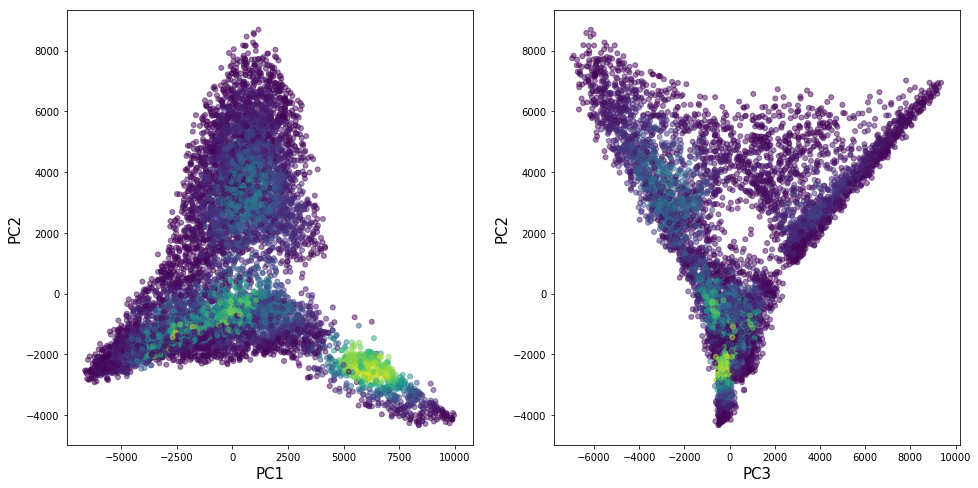

In [15]:
fig = plt.figure( figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
cc = density[downed_ind]
ax1.scatter( downed[:,0], downed[:,1], alpha=0.5, s=25, c=cc)
ax2.scatter( downed[:,2], downed[:,1], alpha=0.5, s=25, c=cc)
ax1.set_xlabel("PC1", fontsize=15), ax1.set_ylabel("PC2", fontsize=15)
ax2.set_xlabel("PC3", fontsize=15), ax2.set_ylabel("PC2", fontsize=15)

In [16]:
file_path = "../test/"

In [17]:
out_graph, out_ids = pcreode.pCreode( data=data, density=density, noise=noise, target=target, file_path=file_path, num_runs=1, cls_thresh=-1.0)

Performing 1 independent runs, may take some time
Number of data points in downsample = 10488
Constructing density kNN
finding endstates
Number of endstates found -> 8
hierarchical placing
consensus aligning
saving files for run_num 1


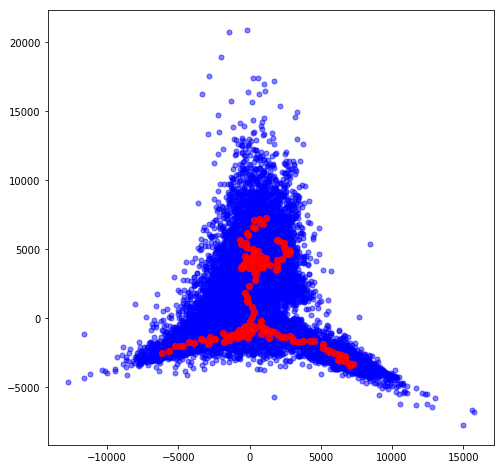

In [21]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = 'blue'
ax1.scatter( data[:,0], data[:,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=40, c='r')


In [23]:
gid = 0
analysis = pcreode.Analysis( file_path=file_path, graph_id=gid, data=data, density=density, noise=noise)

In [26]:
seed = 1

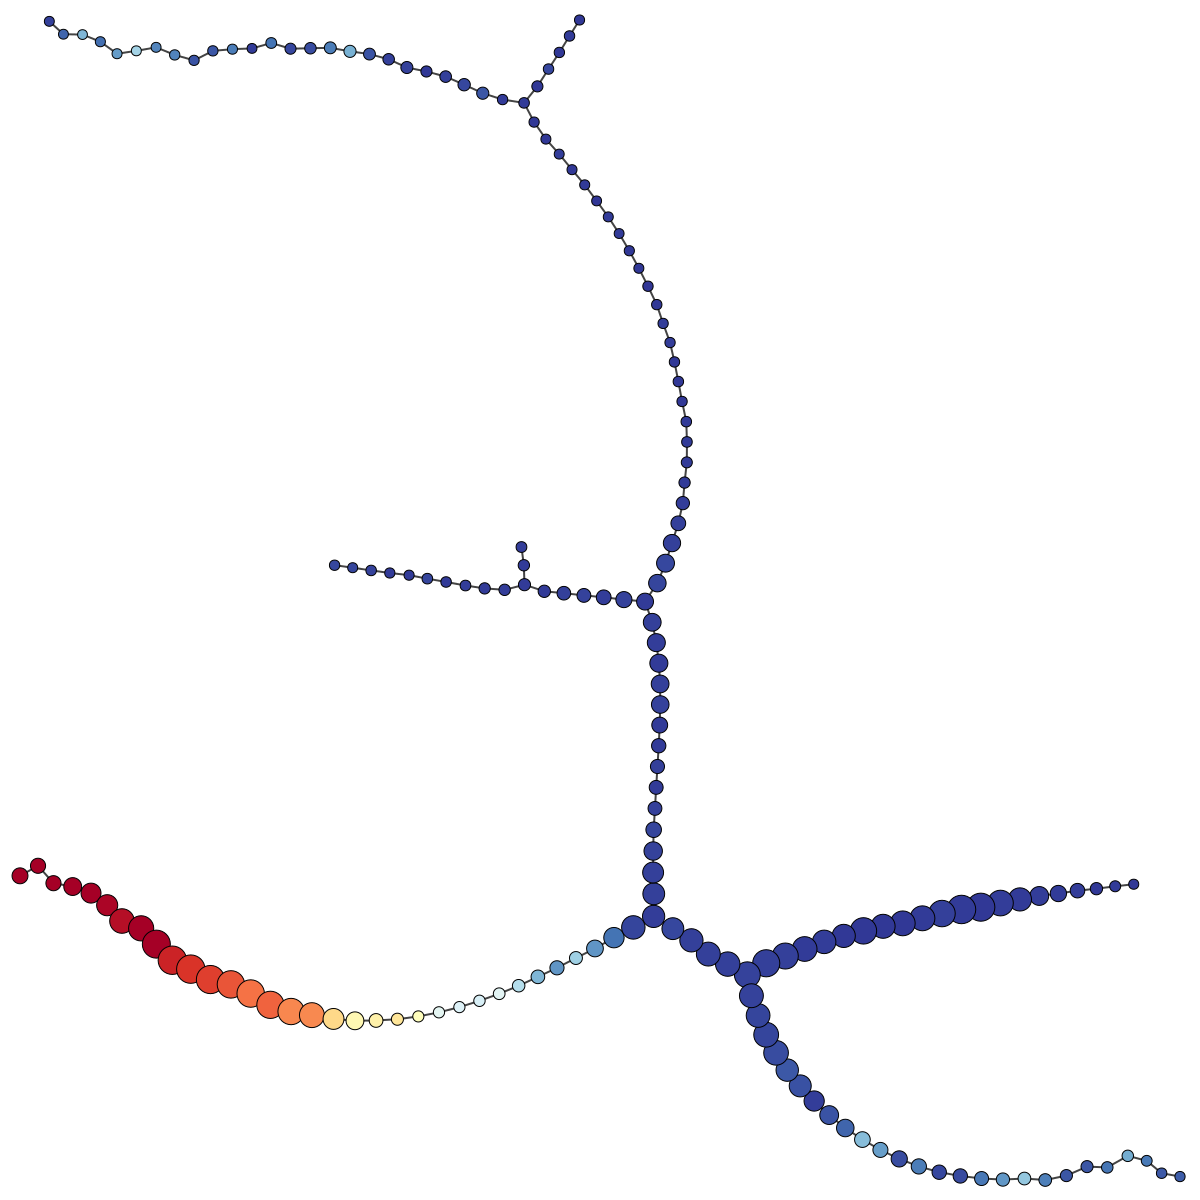

In [29]:
analysis.plot_save_graph( seed=seed, overlay=data_raw.Median_Memb_CK20, file_out='Muc2', upper_range=2.0)

In [30]:
import igraph as _igraph
import matplotlib.pyplot as _plt
import random
from igraph import *
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans as _KMeans
from sklearn import preprocessing
from sklearn import metrics
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import os as _os

In [87]:
def pCreode( data, density, noise, target, file_path, num_runs=100, potential_clusters=10, cls_thresh=0.0, start_id=0, mute=False):
    ''' 
    Function for running full pCreode algorithm, with the addition of principle component extremes found to be under the closeness threshold added as endstates
    :param data:    numpy ndarray of data set
    :param density: numpy array of calculated densities for each datapoint
    :param noise:   value for noise threshold, densities below value will be removed during downsampling
    :param target:  value for target density
    :param file_path: path to directory where output files will be stored
    :param num_runs:  number of independent runs to perform, default is 100 
    :param potential_clusters: value for upper range of number of clusters to search for, default value is 10
    :param cls_thresh: value for closeness threshold use to separate potential endstates from transitional cell types default value is 0.0
    :param start_id: integer at which to start labeling output graphs, allows for addition of graphs to previously ran lot
    :param  mute: boolean operator to suppress print statements
    :return: will save creode files in given directory
    '''
    if not ( isinstance( data, np.ndarray)):
        raise TypeError( 'data variable must be numpy ndarray')
    if not ( isinstance( density, np.ndarray)):
        raise TypeError( 'data variable must be numpy array')
    if not ( _os.path.exists( file_path)):
        raise TypeError( 'please supply a valid directory')
        
    # Save sys.stdout to return print output if muted 
    old_stdout = sys.stdout
    # Mute print statements if True
    if( mute==True):
        sys.stdout = open( os.devnull, 'w')
        
    print( "Performing {0} independent runs, may take some time".format( num_runs))
  
    for run_itr in range( num_runs):
        
        # get downsampled dataset
        down, down_ind = pcreode.Down_Sample( data, density, noise, target)

        # array for orginal density (prior to downsampling) of downsampled data points
        down_density = density[down_ind]
        n_down       = len( down)

        # get distance matrix for down sampled dataset
        Dist = np.array( pairwise_distances( down, down, n_jobs=1))

        # set upper and lower thresholds for number of neighbors to connect in density 
        # based nearest neighbor graph (d-kNN) (current fixed values are 2 and 10)
        upper_nn = 25
        lower_nn = 2

        # assign number of neighbors to connect to, to each datapoint 
        sorted_nn = np.linspace( lower_nn, upper_nn, n_down, dtype=int)
        nn = np.zeros( n_down, dtype=int)
        nn[np.argsort( down_density)] = sorted_nn

        # create adjacency matrix to hold neighbor connections for d-kNN
        knn_adj = np.zeros( ( n_down, n_down), dtype=int)
        for zz in range( n_down):
            knn_adj[zz,np.argsort( Dist[zz,:])[1:nn[zz]]] = 1
        # to make symetric add adj with transpose
        knn_adj = np.add( knn_adj, knn_adj.T)
        
        # make sure there is only one component by constructing a MST
        Dist_csr = csr_matrix( np.triu(Dist))
        Tcsr     = minimum_spanning_tree( Dist_csr)
        mst_adj  = pd.DataFrame( Tcsr.todense()).values
        mst_adj  = np.add( mst_adj, mst_adj.T)
        
        # add the two adjacency matrices
        adj = np.add( knn_adj, mst_adj)
        
        # make sure overlaping neighbors arnt double counted
        adj[adj>0] = 1.0

        # normalize the orginal densities of the downsampled data points
        norm = preprocessing.MinMaxScaler()
        dens_norm = np.ravel( norm.fit_transform( down_density.reshape( -1, 1).astype( np.float)))

        # weight edges of d-kNN by inverse of orginal densities
        den_adj = np.zeros( ( n_down, n_down), dtype=float)
        print( "Constructing density kNN")
        # get coordinates of connections from adjacency matrix
        adj_coords = np.nonzero( np.triu( adj))
        for hh, uu in zip( adj_coords[0], adj_coords[1]):
            # take the minimum density of nodes connected by the edge
            # add 0.1 so that no connection is lost (not equal to zero)
            den_adj[hh,uu] = 1.1 - ( min( [dens_norm[hh], dens_norm[uu]]))
        # make symetric 
        den_adj  = np.add( den_adj, den_adj.T)
        # final edge weights are product of density weights and distance matrix
        dist_weighted_adj = np.multiply( Dist, adj)
        dens_weighted_adj = np.multiply( Dist, den_adj)
        # create undirected igraph instance using weighted matrix
        d_knn = _igraph.Graph.Weighted_Adjacency( dist_weighted_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)

        print( "finding endstates")
        # get closeness of graph and standardize to aid in endstate identification
        cls     = np.array( d_knn.closeness( weights="weight"))
        scaler  = preprocessing.StandardScaler()
        std_cls = scaler.fit_transform( cls.reshape(-1,1)).ravel()

        # using closeness as threshold (default value = 0.0) get potential endstates
        low_cls = down[std_cls<=cls_thresh]
        # array to hold silhouette score for each cluster try
        sil_score = [0]*potential_clusters

        # prefrom K means clustering and score each attempt
        for ss in range( potential_clusters):
            kmeans_model  = _KMeans( n_clusters=ss+2, random_state=10).fit( low_cls)
            label         = kmeans_model.labels_
            sil_score[ss] = metrics.silhouette_score( low_cls, labels=label, metric='l2')

        # find most likely number of clusters from scores above and double to allow for rare cell types
        num_clusters = ( np.argmax( sil_score) + 2)# * 2
        clust_model = _KMeans( n_clusters=num_clusters, random_state=10).fit( low_cls)
        label      = clust_model.labels_
        print( "Number of endstates found -> {0}".format( num_clusters))

        endstates = clust_model.cluster_centers_
        endstates_ind = np.zeros( (num_clusters, 1), dtype=int)
        for ii in range( num_clusters):
            endstates_ind[ii] = pcreode.find_closest_ind( endstates[ii], down)
        
        endstates_ind = endstates_ind.ravel()
        endstates = data[endstates_ind,:]
        num_clusters = len( endstates_ind)
        cen_ind = endstates_ind
        '''
        # Endstate data points were picked from full data set, so need to be appended to down and down_ind
        # Create array to hold where end_states are located within the downsampled dataset
        cen_ind = np.zeros( num_clusters, dtype=int)
        ind = n_down
        for es in range( num_clusters):
            # first need to check if they are already in the graph, if not:
            if( ~np.in1d( endstates_ind[es], down_ind)):
                down     = np.vstack( ( down, endstates[es]))
                down_ind = np.append( down_ind, endstates_ind[es])
                cen_ind[es] = ind
                ind = ind + 1
            # if data point is already in down
            else:
                cen_ind[es] = np.argwhere( endstates_ind[es]==down_ind).ravel()[0]
                continue
        '''
        # re-initialize using density and distance weighted edges         
        dens_knn = _igraph.Graph.Weighted_Adjacency( dens_weighted_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)
        '''
        # add endstate data points to the already constructed dens_knn graph, connecting to 2 closest neighbors
        # future update will so that number of edges is based on density of data point
        knn_num = 5
        # add nodes to graph that will represent endstates
        dens_knn.add_vertices( num_clusters)
        d_knn.add_vertices( num_clusters)
        # get distance matrix to be used for finding closeset neighbors in graph
        end_dist = np.array( pairwise_distances( endstates, down[:-num_clusters], n_jobs=1))
        for kk in range( num_clusters):
            edg_wts = np.sort( end_dist[kk,:])[1:knn_num+1]
            edg_ids = np.argsort( end_dist[kk,:])[1:knn_num+1]
            for jj in range( knn_num):
                # no need to connect if connection is already present
                if( edg_wts[jj]<2.0e-06):
                    continue
                # if not present add edge with distance/density weight
                else:
                    dens_knn.add_edge( cen_ind[kk], edg_ids[jj], weight=edg_wts[jj]*(1-dens_norm[edg_ids[jj]]))
                    d_knn.add_edge( cen_ind[kk], edg_ids[jj], weight=edg_wts[jj])
        '''            
        print( "hierarchical placing")
        # perform hierarchical placement of endstates (find shortest paths connecting them within d_knn)
        hi_pl, hi_pl_ind = pcreode.hierarchical_placement( dens_knn, cen_ind)
        print( "consensus aligning")
        # perform consensus alignment of hierarchical placement data points
        aligned_ind = pcreode.consensus_alignment( down, hi_pl_ind.copy(), data, density, noise)
        # add orginal endstates back into aligned list of indices 
        al_es_ind = np.append( cen_ind, np.unique( aligned_ind[~np.in1d( aligned_ind, cen_ind)]))
        # perform hierarchical placement of of newly aligned data points
        al_hi_pl, al_hi_pl_ind = pcreode.hierarchical_placement( dens_knn, al_es_ind)
        # rerun hierarchical placement on the aligned placement graph to eliminate superfluous edges
        # by re-feeding it the orginal endstate indices
        creode_graph, creode_ind = pcreode.hierarchical_placement( al_hi_pl, range( len( cen_ind)))
        creode_graph.simplify( combine_edges="mean")
        print( "saving files for run_num {0}".format( run_itr + 1))
        np.savetxt( file_path + "ind_{0}.csv".format( start_id), down_ind[al_hi_pl_ind[creode_ind]], delimiter=',')
        creode_graph.save( file_path + "adj_{0}.txt".format( start_id), format="adjacency" )
        
        start_id = start_id + 1
        
    # return to normal treatment of print statements
    sys.stdout = old_stdout
        
    return( creode_graph, down_ind[al_hi_pl_ind[creode_ind]], down_ind, d_knn, al_hi_pl_ind[creode_ind], cen_ind, dens_weighted_adj, hi_pl, hi_pl_ind, dens_knn)
    

In [88]:
out_graph, out_ids, down_ind, d_knn, run_ind, cen_ind, dens_adj, hi_pl, hi_pl_ind, dens_knn = pCreode( data=data, density=density, noise=noise, target=target, file_path=file_path, num_runs=1, cls_thresh=-1.0)
down = data[down_ind]

Performing 1 independent runs, may take some time
Number of data points in downsample = 10406
Constructing density kNN
finding endstates
Number of endstates found -> 5
hierarchical placing
consensus aligning
saving files for run_num 1


In [89]:
# find all branch points
degree   = np.transpose( out_graph.degree())
brch_ids = np.argwhere( degree>2).flatten()

In [125]:
# get neighbors of branching nodes
def get_neighbors( nodes): 
    brnb_ids = nodes
    for ii in nodes:
        brnb_ids = np.append( brnb_ids, out_graph.neighbors(ii))
    return( brnb_ids)

nn = get_neighbors( brch_ids)
for ii in range( 5):
    nn = np.append( nn, np.unique( get_neighbors( nn))) 
nn_ids = np.unique( nn)
nn_ids

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 49, 50,
       51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 94, 95, 96, 97, 98, 99])

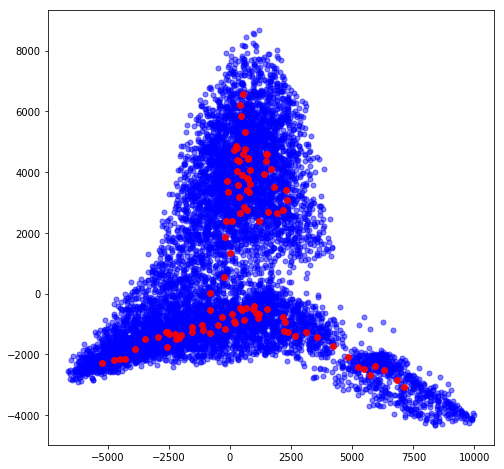

In [126]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = "blue"
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=35, c='r')

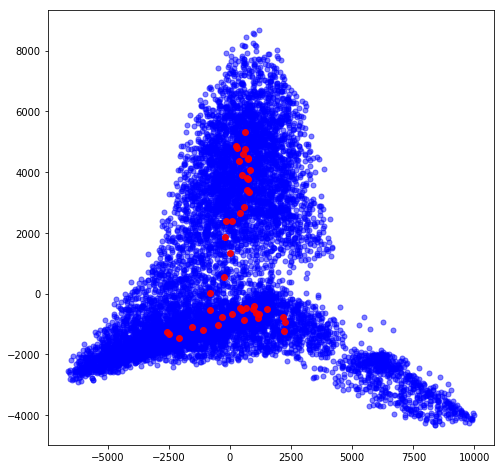

In [127]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = "blue"
ax1.scatter( down[:,0], down[:,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids[nn_ids],0], data[out_ids[nn_ids],1], alpha=0.9, s=35, c='r')

In [128]:
# get graph distance matrix to bin data to nodes
g_dist = pcreode.get_graph_distance( np.arange( d_knn.vcount()), run_ind, d_knn)

In [129]:
# bin downsampled data points to each node
bin_id = np.argsort( g_dist, axis=1)[:,1]
len(bin_id), nn_ids

(10406,
 array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 49, 50,
        51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
        70, 71, 72, 73, 94, 95, 96, 97, 98, 99]))

In [130]:
brch_bins = np.zeros_like( bin_id)
no_branch_ids = np.array( [], dtype=int)
for ii in nn_ids:
    brch_bins[np.argwhere( bin_id==ii).ravel()] = 1
no_branch_ids = np.argwhere(brch_bins==0).ravel()
nono_branch_ids = np.argwhere(brch_bins==1).ravel() 

no_branch_ids

array([    0,     1,     2, ..., 10388, 10389, 10404])

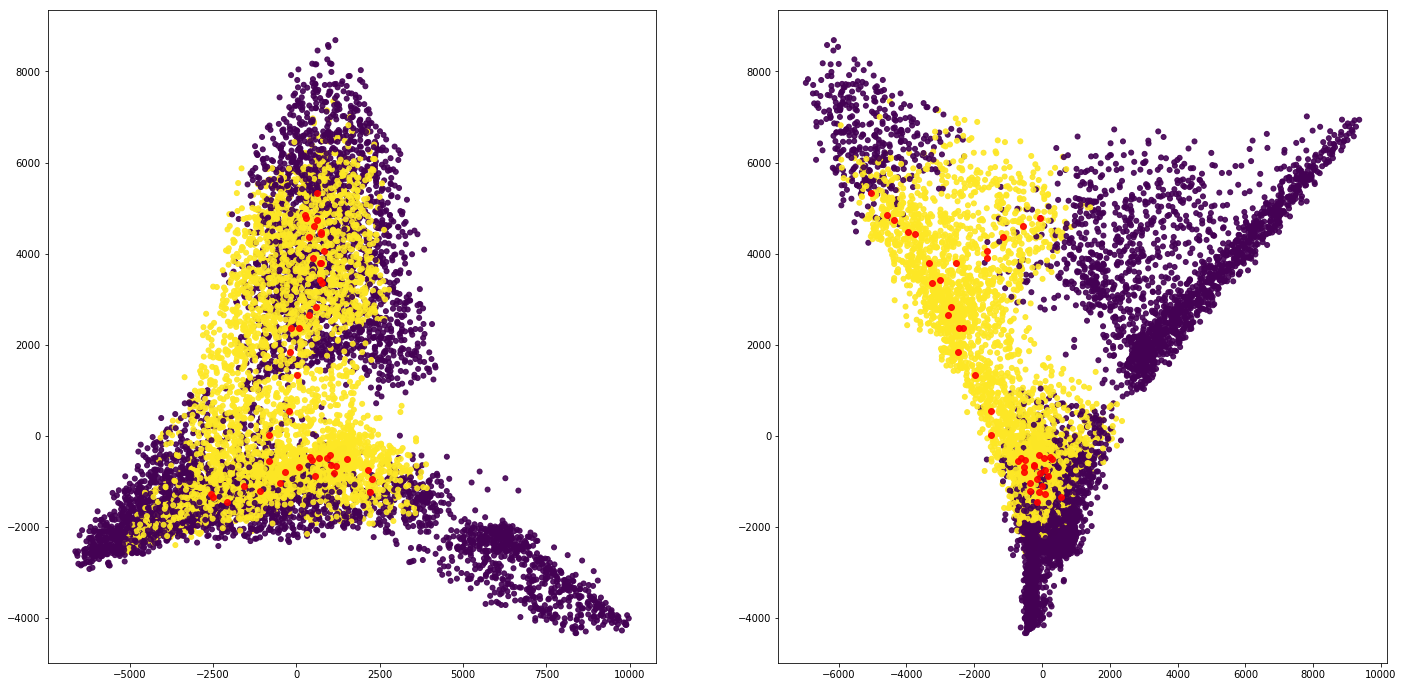

In [131]:
fig = plt.figure( figsize=(24,12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
cc = brch_bins
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.9, s=25, c=cc)
ax1.scatter( data[out_ids[nn_ids],0], data[out_ids[nn_ids],1], alpha=0.9, s=35, c='r')
ax2.scatter( data[down_ind,2], data[down_ind,1], alpha=0.9, s=25, c=cc)
ax2.scatter( data[out_ids[nn_ids],2], data[out_ids[nn_ids],1], alpha=0.9, s=35, c='r')

In [132]:
no_branch_data = data[down_ind[no_branch_ids],:]

In [133]:
# create new knn graphs with branching data points removed
# set upper and lower thresholds for number of neighbors to connect in density 
# based nearest neighbor graph (d-kNN) (current fixed values are 2 and 10)
upper_nn = 25
lower_nn = 2

# need to recalculate the density of no_branch_data
br_dens = pcreode.Density( no_branch_data)
br_density = br_dens.get_density( radius=0.80)

calculating densities for datapoints: 0 -> 4999
calculating densities for datapoints: 5000 -> 5679
****Always check density overlay for radius fit****


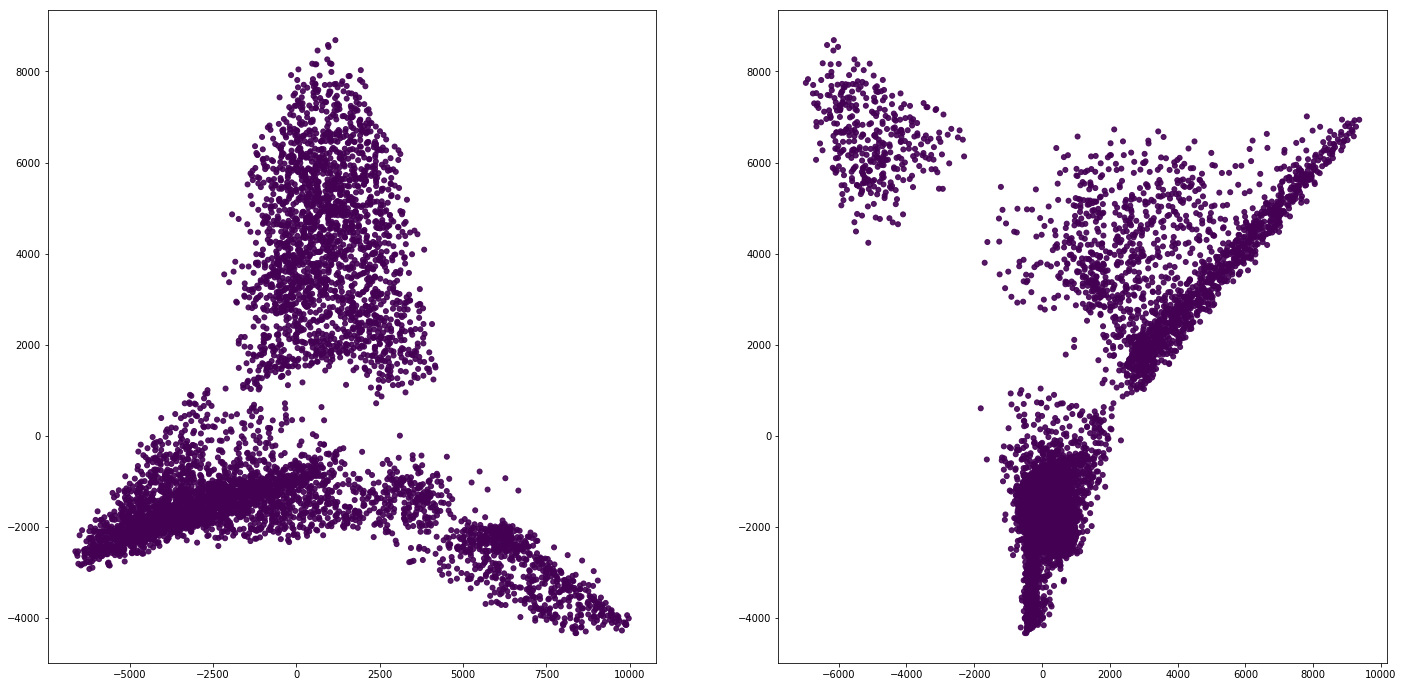

In [134]:
fig = plt.figure( figsize=(24,12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
cc = br_density
ax1.scatter( no_branch_data[:,0], no_branch_data[:,1], alpha=0.9, s=25, c=cc)
ax2.scatter( no_branch_data[:,2], no_branch_data[:,1], alpha=0.9, s=25, c=cc)

In [135]:
# assign number of neighbors to connect to, to each datapoint 
br_sorted_nn = np.linspace( lower_nn, upper_nn, len( no_branch_data), dtype=int)
br_nn = np.zeros_like( br_density)
br_nn[np.argsort( br_density)] = br_sorted_nn

# create adjacency matrix to hold neighbor connections for d-kNN
br_knn_adj = np.zeros( ( len( br_density), len( br_density)), dtype=int)
br_dist = pairwise_distances( no_branch_data, no_branch_data)
for zz in range( len( br_density)):
    br_knn_adj[zz,np.argsort( br_dist[zz,:])[1:br_nn[zz]]] = 1
# to make symetric add adj with transpose
br_knn_adj = np.add( br_knn_adj, br_knn_adj.T)
br_knn_adj[br_knn_adj>0] = 1.0
br_dist_weighted_adj = np.multiply( br_dist, br_knn_adj)
brd_knn = _igraph.Graph.Weighted_Adjacency( br_dist_weighted_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)

In [136]:
comps = np.array( brd_knn.components())

In [137]:
cocl = np.zeros_like( br_density)
for ii in range( len( comps)):
    cocl[comps[ii]] = ii * 10

In [138]:
br_ends = np.zeros_like( cen_ind)
for ii, cen_itr in enumerate( cen_ind):
    br_ends[ii] = pcreode.find_closest_ind( point=data[down_ind[cen_itr]], data=no_branch_data)
br_ends

array([ 965, 4388, 5181, 2770,  641])

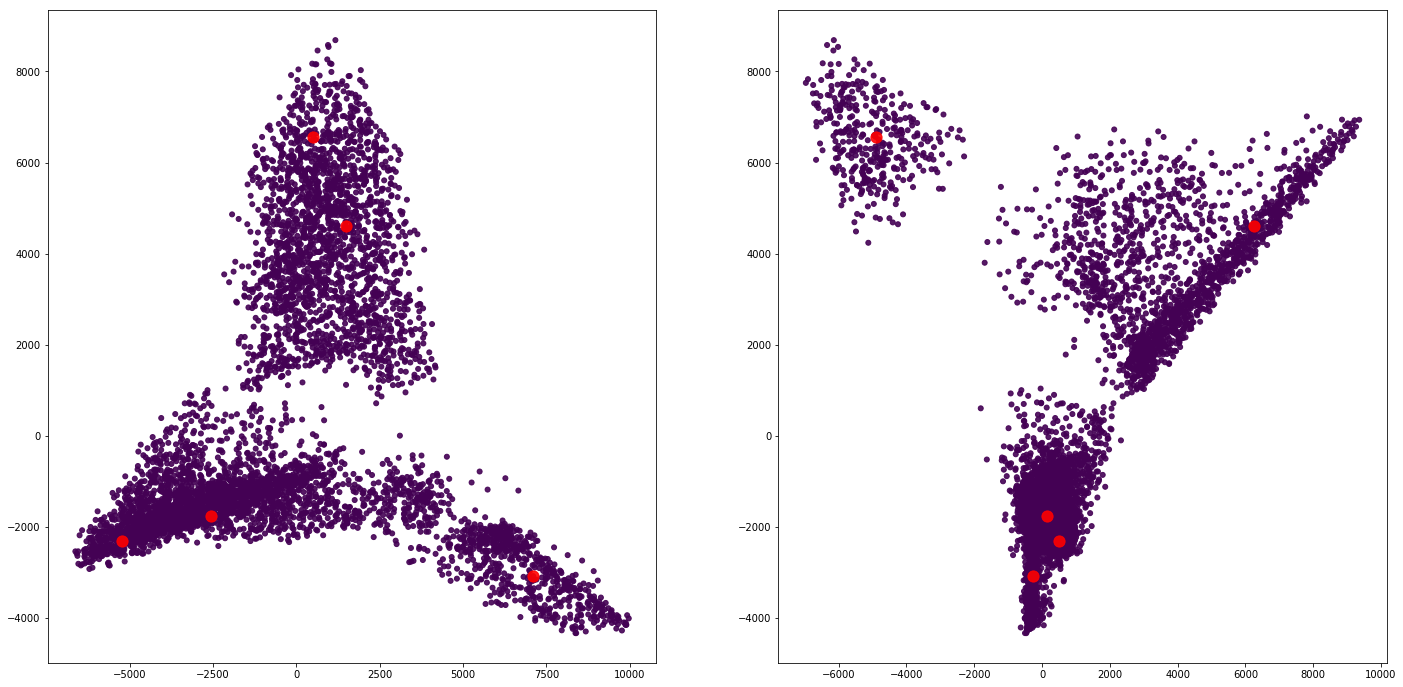

In [139]:
fig = plt.figure( figsize=(24,12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
cc = cocl
ax1.scatter( no_branch_data[:,0],       no_branch_data[:,1],       alpha=0.9, s=25,  c=cc)
ax1.scatter( no_branch_data[br_ends,0], no_branch_data[br_ends,1], alpha=0.9, s=125, c='r')
ax2.scatter( no_branch_data[:,2],       no_branch_data[:,1],       alpha=0.9, s=25,  c=cc)
ax2.scatter( no_branch_data[br_ends,2], no_branch_data[br_ends,1], alpha=0.9, s=125, c='r')

In [140]:
comp_adj = dens_adj.copy()
# remove all branching data point edges
comp_adj[nono_branch_ids,:] = 0
comp_adj[:,nono_branch_ids] = 0

# remove all data points with less than 2 pcreode endstates in them
for cc in range( len( comps)):
    if( sum(xx in comps[cc] for xx in br_ends)<=1):
        comp_adj[no_branch_ids[comps[cc]],:] = 0
        comp_adj[:,no_branch_ids[comps[cc]]] = 0
    else:
        print "yes"
        
len( np.nonzero( comp_adj)[0])

yes


67368

In [141]:
comp_knn = _igraph.Graph.Weighted_Adjacency( comp_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)

In [142]:
#print comp_knn.components()
comps = np.array( comp_knn.components())
cocl = np.zeros_like( down_ind)

cocl[comps[0]] = 1 

In [143]:
cen_ind

array([1333, 6755, 8834, 3709,  856])

In [144]:
run_ind

array([1333, 6755, 8834, 3709,  856, 4520,  839, 1884, 2711, 1355, 3329,
       1393, 1363, 8625, 5537, 9463, 9530, 6825, 8325, 9300, 8555, 7346,
       2848, 3624, 2758,  927, 7623, 1846, 7637, 1632, 2824, 2793, 1430,
       6380, 5177, 1149, 3981, 8397, 7813, 2359, 3515, 4876, 3706, 2569,
       2551, 1186, 7816, 1945, 6458, 2821,   84, 7786, 6939, 6443, 9165,
       7185, 8172, 9973, 9241, 9964, 9547, 8026, 9515, 6730, 8147, 6554,
       7260, 8056, 6105, 8185, 9939, 9989, 6649, 8657, 1296, 5056,  321,
       1574, 1539,  306, 2368, 1158, 4838, 2388, 1183, 3464, 3472, 3463,
       3514, 3458, 1506, 3466, 5235, 9795, 2163, 4644, 4639, 2028, 6376,
       7216])

In [145]:
comp_ends = hi_pl_ind[np.isin( hi_pl_ind, comps[0])]
comp_ends

array([1333, 6755, 3709,  856, 7813, 8397, 7683, 2102, 1430, 2793, 2824,
       3659, 3638, 3211, 3703, 4520, 2359, 3515, 4876, 3706, 7909, 4048,
       2452, 1600, 5681, 3763, 2289, 1272, 3483, 1322,  141, 1354, 2360])

In [146]:
alt_rte, alt_ind = pcreode.hierarchical_placement( comp_knn, comp_ends)

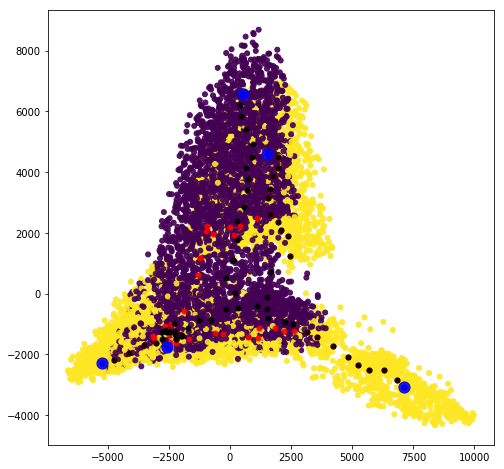

In [147]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = cocl
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.9, s=25, c=cc)
ax1.scatter( data[down_ind[alt_ind],0], data[down_ind[alt_ind],1], alpha=0.9, s=25, c='r')
ax1.scatter( data[down_ind[hi_pl_ind],0], data[down_ind[hi_pl_ind],1], alpha=0.9, s=25, c='black')
ax1.scatter( data[down_ind[cen_ind],0], data[down_ind[cen_ind],1], alpha=0.9, s=125, c='blue')


In [148]:
# combine alternate route graph and pcreode graph node indices, downsampled indices
all_inds = np.unique( np.append( hi_pl_ind, alt_ind))

In [149]:
# run consensus alignment on combined alternate route and pcreode graph
all_aligned_ind = pcreode.consensus_alignment( data[down_ind], all_inds.copy(), data, density, noise)
all_aligned_ind

array([   14,    66,    90,   111,   112,   228,   400,   506,  1283,
        1285,  1441,  1553,  1675,  1839,  2090,  2287,  2394,  2435,
        2542,  2569,  2786,  2799,  2848,  2882,  2909,  3138,  3279,
        3382,  3545,  3606,  3771,  3875,  3975,  4057,  4075,  4595,
        4662,  4897,  5044,  5095,  5112,  5150,  5181,  5273,  5451,
        5503,  5511,  5621,  5641,  5923,  6495,  6520,  6567,  6704,
        6782,  6871,  6944,  7080,  7196,  7226,  7426,  7460,  7566,
        7583,  7729,  7810,  7842,  7903,  8079,  8164,  8179,  8221,
        8299,  8414,  8543,  8576,  8667,  8763,  8829,  8868,  9131,
        9211,  9237,  9251,  9538,  9642,  9771,  9871,  9904, 10016,
       10133, 10396])

In [150]:
# add orginal endstates back into aligned list of indices 
all_es_ind = np.append( cen_ind, np.unique( all_aligned_ind[~np.in1d( all_aligned_ind, cen_ind)]))
cen_ind, all_es_ind

(array([1333, 6755, 8834, 3709,  856]),
 array([ 1333,  6755,  8834,  3709,   856,    14,    66,    90,   111,
          112,   228,   400,   506,  1283,  1285,  1441,  1553,  1675,
         1839,  2090,  2287,  2394,  2435,  2542,  2569,  2786,  2799,
         2848,  2882,  2909,  3138,  3279,  3382,  3545,  3606,  3771,
         3875,  3975,  4057,  4075,  4595,  4662,  4897,  5044,  5095,
         5112,  5150,  5181,  5273,  5451,  5503,  5511,  5621,  5641,
         5923,  6495,  6520,  6567,  6704,  6782,  6871,  6944,  7080,
         7196,  7226,  7426,  7460,  7566,  7583,  7729,  7810,  7842,
         7903,  8079,  8164,  8179,  8221,  8299,  8414,  8543,  8576,
         8667,  8763,  8829,  8868,  9131,  9211,  9237,  9251,  9538,
         9642,  9771,  9871,  9904, 10016, 10133, 10396]))

In [151]:
# perform hierarchical placement of newly aligned data points
all_hi_pl, all_hi_pl_ind = pcreode.hierarchical_placement( dens_knn, all_es_ind)

In [152]:
# hierarchical placement assumes there are no loops therefore only tests for 
# one complete graph component, so the loop needs to be connected at both ends
# only one end connected at this point.
# the missing connection will be the greatest difference between graph distance and 
# euclidean distance

# get graph distance for all nodes
graph_dist = pcreode.get_graph_distance( range( len( all_hi_pl_ind)), range( len( all_hi_pl_ind)), all_hi_pl)
# euclidean distance
euc_dist = pairwise_distances( data[down_ind[all_hi_pl_ind]], data[down_ind[all_hi_pl_ind]]) 

In [153]:
# find the maximum difference in distances 
loose_ends = np.unravel_index( np.argmax( np.subtract( graph_dist, euc_dist)), graph_dist.shape, order='C')
loose_ends[::-1]

(34, 44)

In [154]:
# get adjacency matrix
start_adj = np.array( all_hi_pl.get_adjacency(type=GET_ADJACENCY_BOTH).data)
start_adj.shape, start_adj[loose_ends]

((275, 275), 0)

In [155]:
# connect the loose ends
start_adj[loose_ends] = 1
start_adj[loose_ends[::-1]] = 1
start_adj[loose_ends[0],loose_ends[1]]

1

In [156]:
alter_nodes = down_ind[all_hi_pl_ind]

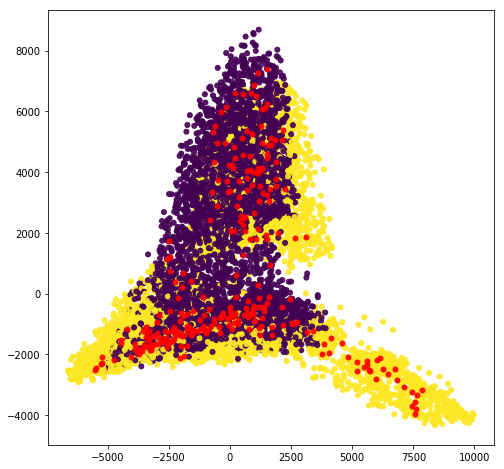

In [157]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = cocl
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.9, s=25, c=cc)
ax1.scatter( data[alter_nodes,0], data[alter_nodes,1], alpha=0.9, s=25, c='r')

In [158]:
# now the unwanted endstates need to be removed
# these should sum to 1, so we iter through and remove until 
# we only have our original endstates 
ends = range( len(cen_ind))
sum1 = np.argwhere( np.sum( start_adj, axis=0)==1).flatten()
# placeholder for nodes to keep after triming
itr_inds = alter_nodes

while( ~np.alltrue( np.isin( sum1, ends))):
    
    # find all nodes with degree of 1, eg the ends
    sum1 = np.argwhere( np.sum( start_adj, axis=0)==1).flatten()
    # keep only the ones that are not flagged by pcreode as endstates
    sum1_notends = sum1[~np.isin( sum1, ends)]
    # delete the unwanted end nodes
    start_adj = np.delete( start_adj, sum1_notends, axis=0)
    start_adj = np.delete( start_adj, sum1_notends, axis=1)
    # keep track of which of the data nodes we are keeping
    itr_inds = np.delete(  itr_inds,  sum1_notends)
    start_adj.shape

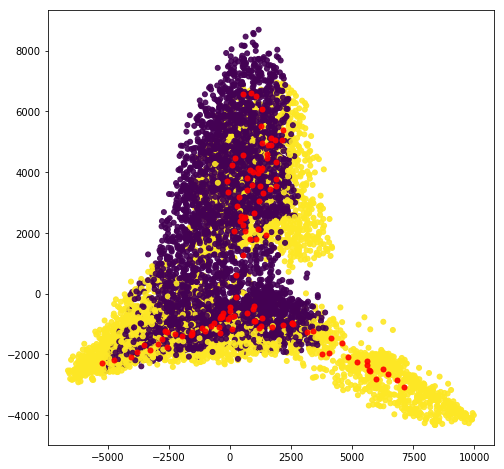

In [159]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = cocl
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.9, s=25, c=cc)
ax1.scatter( data[itr_inds,0], data[itr_inds,1], alpha=0.9, s=25, c='r')